In [30]:
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
import json
import os

In [31]:
con = psycopg2.connect(dbname='gdelt_updates', user='postgres', password='postgres', host='localhost')
cur = con.cursor()

## Number of Articles for the Term "Hate" Over Time

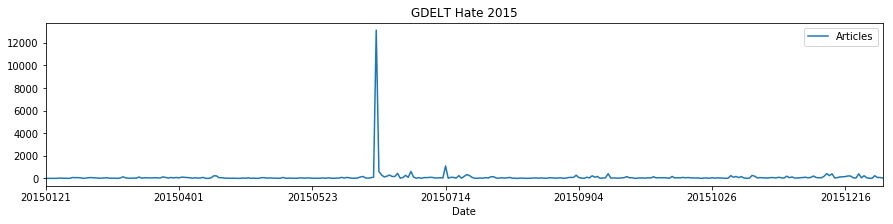

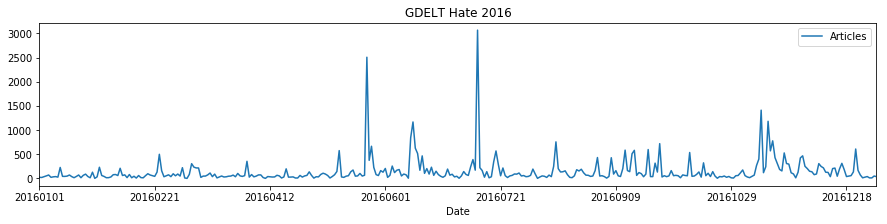

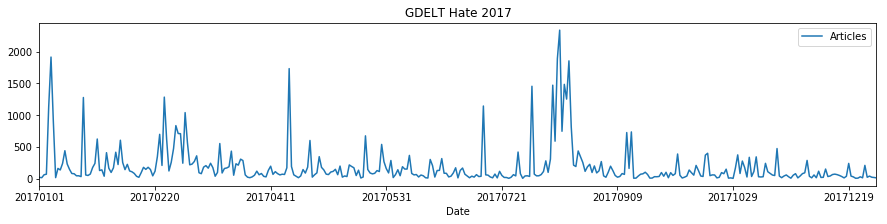

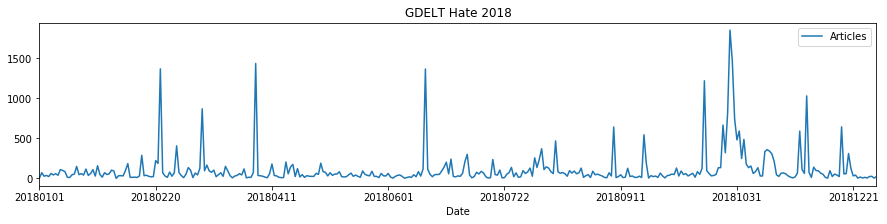

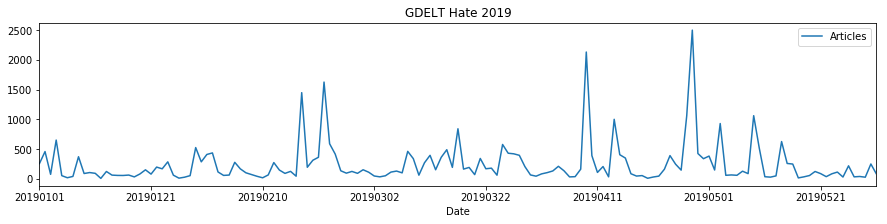

In [32]:
for year in [2015, 2016, 2017, 2018, 2019]:
    
    cur.execute('''
                select sqldate, sum(numarticles) 
                from gdelt_hate
                where left(sqldate, 4)::integer = {0}
                group by sqldate order by sqldate
                '''.format(year))
    
    h_df = pd.DataFrame([r for r in cur.fetchall()], columns=['Date', 'Articles'])
    h_df.plot(x='Date', y='Articles', figsize=(15, 3), title='GDELT Hate {}'.format(year))

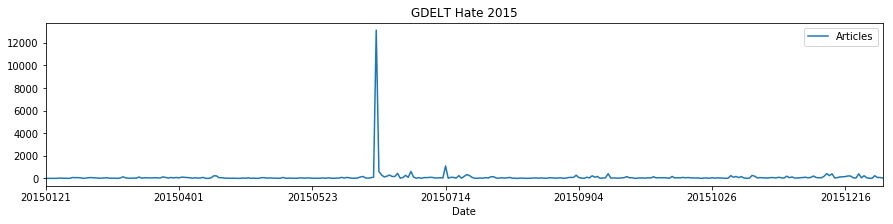

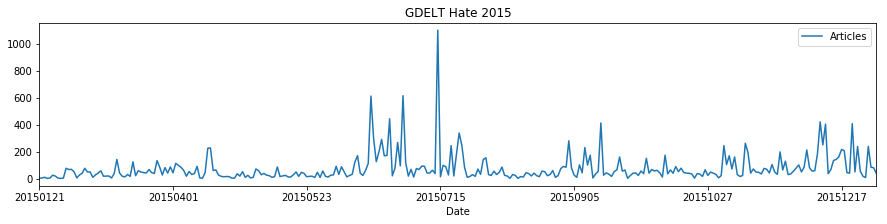

In [33]:
cur.execute('''
            select sqldate, sum(numarticles) 
            from gdelt_hate
            where left(sqldate, 4)::integer = 2015
            group by sqldate order by sqldate
            ''')
h_df = pd.DataFrame([r for r in cur.fetchall()], columns=['Date', 'Articles'])
h_df.plot(x='Date', y='Articles', figsize=(15, 3), title='GDELT Hate 2015'.format(year))
h_df[h_df.Date != '20150618'].plot(x='Date', y='Articles', figsize=(15, 3), title='GDELT Hate 2015'.format(year))